In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

import scipy.signal
from scipy.io import wavfile

import librosa 
from sklearn.preprocessing import StandardScaler

import zipfile
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout ,Flatten , GlobalAveragePooling2D, Resizing, Rescaling
from tensorflow.keras.layers import Layer

import IPython.display as ipd


In [2]:
df = pd.read_csv('UrbanSound8K\\UrbanSound8K.csv')

In [97]:
df.shape

(8732, 9)

In [4]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
df['duration'] = df['end']- df['start']

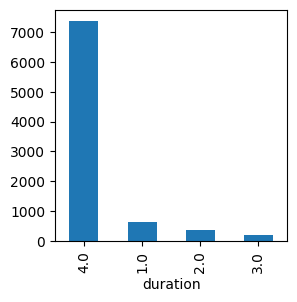

In [6]:
plt.figure(figsize=(3,3))
df['duration'].round().value_counts().head(4).plot(kind='bar')
plt.show()

In [7]:
dog_bark_le2 = 'UrbanSound8K\\fold5\\100032-3-0-0.wav'
dog_bark_ge2 ='UrbanSound8K\\fold6\\101281-3-0-14.wav' 

audio shape (7002,)  , sample rate 22050
Audio has a duration of 0.32 seconds len of sample is  7002  , original sample rate 22050


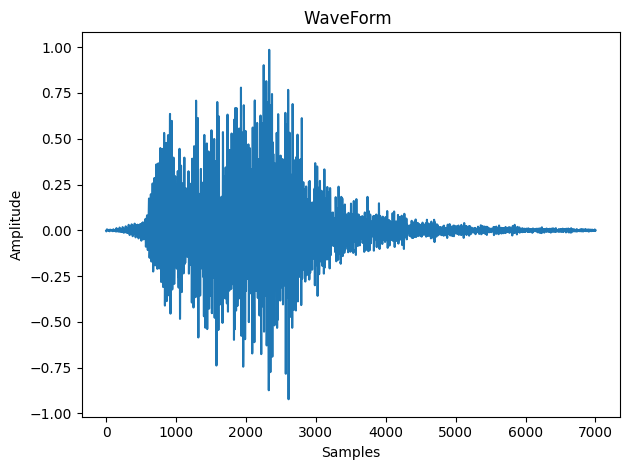

In [8]:
y , sr = librosa.load(dog_bark_le2)
print(f'audio shape {y.shape}  , sample rate {sr}')
time_sec = len(y)/sr
print(f"Audio has a duration of {time_sec:.2f} seconds len of sample is  {len(y)}  , original sample rate {sr}")
plt.plot(y)
plt.title('WaveForm ')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


In [120]:
## Resmaple the Data
def resample_data(filename, new_sr=8000):
    y,sr = librosa.load(filename)
    resampled_audio = librosa.resample(y,orig_sr=sr,target_sr=new_sr)
    time_sec_resample = len(resampled_audio)/new_sr
    return resampled_audio , new_sr

resample_audio ,new_sr= resample_data(dog_bark_ge2)

In [121]:
def pad_mfccs_func(filename,mfcc=13,new_sr = 8000):
    try:
        # load the file 
        y ,new_sr = resample_data(filename)
        
        # padding
        target_len = int(3.0*new_sr) 
        y = y[:target_len]
        pad = target_len - len(y)
        
        if pad > 0 :
            y = np.pad(y , pad_width=(0,pad),mode= 'constant') 
        

        mfccs =librosa.feature.mfcc(y=y,sr=sr,n_mfcc=mfcc,hop_length=512)
        delta_mfccs = librosa.feature.delta(mfccs,order = 1)
        delta2_mfccs = librosa.feature.delta(delta_mfccs,order=2)
        combined_mfccs = np.vstack([mfccs,delta_mfccs,delta2_mfccs])
        scaler = StandardScaler()
        combined_mfccs = scaler.fit_transform(combined_mfccs.T).T
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

        
    return combined_mfccs


(39, 47)


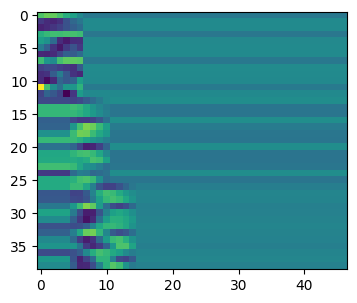

In [12]:
plt.figure(figsize=(4,4))
mfccs_pad = pad_mfccs_func(dog_bark_le2)
print(mfccs_pad.shape)
plt.imshow(mfccs_pad)
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [14]:
base_path = 'UrbanSound8K'
X = []
y = []
for i,row in tqdm(df.iterrows(),total = len(df)):
    file_path = os.path.join(base_path, "fold"+str(row["fold"]), row["slice_file_name"])
    mfccs_i = pad_mfccs_func(file_path)
    if mfccs_i is not None:
        X.append(mfccs_i)
        y.append(row['classID'])

    

 41%|████      | 3590/8732 [01:12<01:45, 48.73it/s]C:\Users\Shivraj\AppData\Local\Temp\ipykernel_14032\608997096.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y,sr = librosa.load(filename)
d:\ML_DL_Project\Computer Vision\p4\audio_dl\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 41%|████▏     | 3602/8732 [01:13<01:39, 51.78it/s]

Error processing UrbanSound8K\fold9\174282-6-0-0.wav: 


100%|██████████| 8732/8732 [02:52<00:00, 50.54it/s]


In [15]:
X = np.array(X)

y = np.array(y)

In [16]:
num_classes = len(np.unique(y))
num_classes

10

In [144]:
X_train ,X_val , y_train ,y_val = train_test_split(X,y,test_size=0.2,random_state=111)

In [145]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(6984, 39, 47) (1747, 39, 47)
(6984,) (1747,)


In [146]:
X_train = np.expand_dims(X_train,axis=-1)   
X_val   = np.expand_dims(X_val,axis=-1)


In [147]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(6984, 39, 47, 1) (1747, 39, 47, 1)
(6984,) (1747,)


In [148]:
## Model Deep Learning 
audio_model = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(39,47,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])



d:\ML_DL_Project\Computer Vision\p4\audio_dl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [149]:
audio_model.summary()
audio_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics= ['accuracy'])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 39, 47, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 47, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 23, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 23, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 11, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 11, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9, 11, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,594 (514.04 KB)

 Trainable params: 131,114 (512.16 KB)

 Non-trainable params: 480 (1.88 KB)

In [23]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,restore_best_weights=True,start_from_epoch=0)

In [24]:
hist = audio_model.fit(X_train ,y_train,batch_size=32,epochs=50,validation_data=(X_val,y_val))  # ,callbacks = [early_stop]

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.2723 - loss: 2.0231 - val_accuracy: 0.0630 - val_loss: 4.5752
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4158 - loss: 1.6128 - val_accuracy: 0.3160 - val_loss: 2.0618
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4904 - loss: 1.4264 - val_accuracy: 0.4430 - val_loss: 1.5608
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5384 - loss: 1.2907 - val_accuracy: 0.5089 - val_loss: 1.3532
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5795 - loss: 1.1712 - val_accuracy: 0.5226 - val_loss: 1.3480
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6270 - loss: 1.0369 - val_accuracy: 0.4974 - val_loss: 1.5006
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6720 - loss: 0.9104 - val_accuracy: 0.4671 - val_loss: 1.6496
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7063 - loss: 0.8269 - val_accu

In [26]:
val_loss, val_acc = audio_model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5318 - loss: 3.3644
Validation Accuracy: 0.5318


In [27]:
audio_model.save("audio_model.h5")

In [28]:
from tensorflow.keras.models import load_model

audio_model_load = load_model("audio_model.h5")  

In [29]:
df['duration'] = df['end']- df['start']

In [106]:
pred_dict = {row["classID"]: row["class"] for _, row in df.iterrows()}
pred_dict

{3: 'dog_bark',
 2: 'children_playing',
 1: 'car_horn',
 0: 'air_conditioner',
 9: 'street_music',
 6: 'gun_shot',
 8: 'siren',
 5: 'engine_idling',
 7: 'jackhammer',
 4: 'drilling'}

In [153]:
dict_sound_dict = {}
for file_name in os.listdir('test_sound'):
    ex_tf =pad_mfccs_func(os.path.join('test_sound',file_name))
    ex_tf_d = np.expand_dims(ex_tf,axis=0)
    preds =audio_model_load.predict(ex_tf_d,verbose=False)
    pred_class_int = int(np.argmax(preds))
    dict_sound_dict[file_name]  = pred_dict[pred_class_int]
    
    

In [34]:
dict_sound_dict

{}

In [43]:
result_df = pd.DataFrame(list(dict_sound_dict.items()), columns=["slice_file_name", "pred_results_sound"])


In [44]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,duration
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,4.000000
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,4.000000
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,4.000000
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,4.000000


In [45]:
merged_df = pd.merge(result_df, df, how="inner", on="slice_file_name")

In [46]:
merged_df['conversion'] = merged_df['pred_results_sound']  == merged_df['class']

In [47]:
float((merged_df['pred_results_sound']  == merged_df['class']).sum()/merged_df.shape[0])*100

83.33333333333334

In [98]:
merged_df.head(3)

,slice_file_name,pred_results_sound,fsID,start,end,salience,fold,classID,class,duration,conversion
0,72265-3-15-0.wav,children_playing,72265,171.627883,174.899768,2,9,3,dog_bark,3.271885,False
1,72265-3-7-0.wav,dog_bark,72265,72.974715,76.974715,2,9,3,dog_bark,4.000000,True
2,72723-3-0-0.wav,dog_bark,72723,0.000000,1.410612,1,9,3,dog_bark,1.410612,True


In [49]:
merged_df['conversion'].value_counts().reset_index()

,conversion,count
0,True,50
1,False,10


### Gradio UI

In [134]:
def audio_prediction(filename):
    y = pad_mfccs_func(filename)
    y = np.expand_dims(y,axis=0)
    preds =audio_model_load.predict(y,verbose=False)
    pred_class_int = int(np.argmax(preds))

    return pred_dict[pred_class_int]

In [191]:
import gradio as gr

In [193]:
import gradio as gr

theme_1 = gr.themes.Soft(primary_hue="violet", secondary_hue="blue")

with gr.Blocks(theme=theme_1) as demo:
    gr.Markdown("## Audio Classification\nUpload or record audio and get the predicted class.")

    with gr.Row():
        audio_in = gr.Audio(type="filepath", label="Upload or record audio")
        classify_btn = gr.Button("Classify")

    with gr.Row():
        out_label = gr.Textbox(label="Predicted class", interactive=False)

    classify_btn.click(audio_prediction, inputs=[audio_in], outputs=[out_label])

